In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


In [2]:
lm = WordNetLemmatizer()
sw = stopwords.words('english')

In [3]:
df = pd.read_csv('Sentiment.csv')
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [4]:
df.columns

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
df1=df[['sentiment','text']]
df1.head()

# we need to work on sentiments i.e. other information in not required for now so we are creating dataframe with required column 

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [6]:
# df1['sentiment']=df1['sentiment'].drop('Neutral',axis=0)
# df1.head()

In [7]:
df1.drop(df1.index[df1['sentiment'] == 'Neutral'], inplace = True)

# we need to work only on positive and negative sentiments so we can drop neutral setiments for now

In [8]:
df1.head()

,sentiment,text
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
5,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day ..."
6,Negative,RT @warriorwoman91: I liked her and was happy ...


In [9]:
df1.shape

(10729, 2)

In [10]:
df1.isnull().sum()
# No null value is observed

sentiment    0
text         0
dtype: int64

In [11]:
df1.duplicated().sum()
# No Duplicated value is observed

2891

# Q1. Print the total number of positive and negative sentiments. 

In [12]:
df1['sentiment'].value_counts()
# Hence Total Number of positive sentiment are2236 and Total Number of Negative sentiment are 8493

Negative    8493
Positive    2236
Name: sentiment, dtype: int64

## Q2. Build a sequential LSTM model to predict positive  and negative sentiments.

creating funtion for preprocessing to remove/conversion of following<br>
Preprocessing Steps<br>
1) Removal of Punctuations<br>
2) Conversion to Lower Case<br>
3) Word Tokenization<br>
4) Stop words Removal<br>
5) Stemming/Lemmization<br>

6) Vectorization<br>

Other Steps<br>
a) Digits removal<br>
b) Emoji removal<br>
c) Html tags removal<br>

In [13]:
import text_hammer as th

# using this to preprocess text before train model with it

In [14]:
def text_preprocessing(df,col):
#     col = col_name
    df[col] = df[col].progress_apply(lambda x:str(x).lower())
    df[col] = df[col].progress_apply(lambda x: th.cont_exp(x))   
    df[col] = df[col].progress_apply(lambda x: th.remove_emails(x))
    df[col] = df[col].progress_apply(lambda x: th.remove_html_tags(x))
    df[col] = df[col].progress_apply(lambda x: th.remove_stopwords(x))
    df[col] = df[col].progress_apply(lambda x: th.remove_special_chars(x))
    df[col] = df[col].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [15]:
df1 = text_preprocessing(df1, "text")

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

In [16]:
df1.head()

,sentiment,text
1,Positive,retweet scottwalker catch gopdebate night scot...
3,Positive,retweet robgeorge carly fiorina trend hour deb...
4,Positive,retweet danscavino gopdebate w realdonaldtrump...
5,Positive,retweet gregabbott_tx tedcruz on day rescind i...
6,Negative,retweet warriorwoman91 like happy hear go mode...


# WordCloud
## 1) Top most used words in Negative Sentiment

In [66]:
df1_Negative = df1[df1['sentiment']=='Negative']
df1_Negative.shape

(8493, 2)

In [67]:
wt_Negative =[]
for i in df1_Negative['text']:
    wt_Negative.extend(word_tokenize(i))

freq_dist_Negative = FreqDist(wt_Negative).most_common(15)
print(freq_dist_Negative)

[('gopdebate', 8854), ('retweet', 5020), ('rwsurfergirl', 1509), ('trump', 1057), ('fox', 1050), ('candidate', 749), ('debate', 686), ('news', 677), ('realdonaldtrump', 632), ('like', 552), ('people', 520), ('jeb', 513), ('gop', 485), ('question', 479), ('megynkelly', 463)]


In [68]:
df1_Negative = pd.DataFrame(freq_dist_Negative,columns=['word','count'])
df1_Negative.head()

,word,count
0,gopdebate,8854
1,retweet,5020
2,rwsurfergirl,1509
3,trump,1057
4,fox,1050


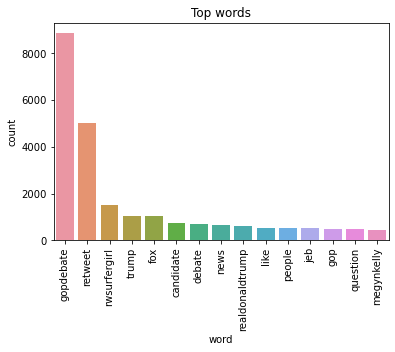

In [69]:
sns.barplot(x='word', y='count', data=df1_Negative)
plt.xticks(rotation=90)
plt.title("Top words")
plt.show()

In [70]:
df1['sentiment'] = df1.sentiment.map({'Positive':0, 'Negative':1})

In [71]:
df1.head()

,sentiment,text
1,0,retweet scottwalker catch gopdebate night scot...
3,0,retweet robgeorge carly fiorina trend hour deb...
4,0,retweet danscavino gopdebate w realdonaldtrump...
5,0,retweet gregabbott_tx tedcruz on day rescind i...
6,1,retweet warriorwoman91 like happy hear go mode...


In [72]:
x = df1['text']
y = df1['sentiment']
print(x.shape)
print(y.shape)

(10729,)
(10729,)


In [73]:
from sklearn.model_selection import train_test_split

In [74]:
x_train,x_test, y_train,y_test = train_test_split(x,y, test_size = 0.25,stratify=y,
                                                  random_state = 42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8046,)
(2683,)
(8046,)
(2683,)


# Tokenization

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [79]:
vocab_size = 15000                         # this means 15000 unique words can be taken 
tk = Tokenizer(vocab_size,lower=True)
df_total = pd.concat([x_train, x_test], axis = 0)
tk.fit_on_texts(df_total)

In [80]:
print(len(tk.word_index))
print(tk.word_counts)

13846
OrderedDict([('water', 16), ('rise', 11), ('fast', 11), ('history', 28), ('catch', 18), ('last', 7), ('nutshell', 8), ('gopdebate', 11179), ('fridayfeeling', 1), ('aldon', 1), ('smith', 2), ('king', 10), ('retweet', 6224), ('chrisjzullo', 6), ('night', 642), ('see', 126), ('bunch', 46), ('rich', 27), ('old', 42), ('despot', 2), ('zero', 15), ('solution', 21), ('nation', 26), ('problem', 81), ('un', 2), ('cjsullivan', 1), ('hope', 57), ('stop', 193), ('isis', 40), ('terrorizing', 1), ('movie', 20), ('theater', 8), ('black', 89), ('church', 31), ('justiceonly', 1), ('foxnew', 462), ('megan', 23), ('kelly', 145), ('tweet', 62), ('httpstcocvkzqinxu1', 1), ('httpstcokihafycss7', 1), ('gop', 577), ('setup', 5), ('fail', 55), ('trumpcarson', 2), ('ticket', 13), ('win', 286), ('landslide', 8), ('realdonaldtrump', 935), ('seanhannity', 15), ('anncoulter', 8), ('republican', 378), ('potus', 57), ('trump2016', 66), ('trump', 1497), ('rwsurfergirl', 1817), ('chris', 372), ('wallace', 349), (

In [81]:
X = tk.texts_to_sequences(x)

In [82]:
for i in range(len(X)):
    print(len(X[i]),end=" ")

12 11 13 15 11 12 11 6 10 6 14 10 14 11 15 13 8 15 14 15 14 15 12 15 13 11 14 9 12 12 14 14 11 7 6 13 6 13 15 13 15 13 11 12 7 17 9 15 6 14 15 10 13 16 15 15 13 9 10 11 13 18 6 7 14 12 10 13 13 15 14 11 13 8 14 12 12 10 13 14 6 14 11 11 13 11 9 8 14 12 7 14 14 9 12 10 13 14 14 14 17 12 14 11 6 13 9 12 8 9 13 5 11 11 14 13 6 11 10 14 14 13 5 13 15 14 7 12 13 11 11 17 14 10 9 12 13 11 13 12 7 12 10 9 13 16 13 10 15 13 13 12 8 15 7 7 7 11 11 13 11 6 11 11 6 14 11 13 9 14 11 11 7 13 12 13 13 11 12 12 14 11 14 10 12 5 12 9 9 14 8 10 14 5 6 10 10 7 13 14 10 7 13 7 8 11 14 16 13 9 3 13 13 14 5 11 14 9 13 10 12 11 17 8 8 13 11 16 5 12 13 8 7 15 14 11 13 6 16 11 8 8 7 12 14 12 5 13 10 12 13 10 12 13 9 13 9 15 4 14 12 11 11 6 10 12 11 11 12 4 11 11 12 11 13 10 10 11 12 15 9 15 15 11 21 15 12 14 4 15 14 12 14 12 13 9 12 12 6 13 11 11 13 13 12 13 13 13 9 12 12 12 3 6 13 13 10 5 13 10 11 13 11 13 12 10 10 9 5 11 12 15 12 8 14 13 9 16 7 13 12 11 9 11 11 11 10 10 6 6 16 12 14 10 13 9 13 14 12 7 11 16

 13 8 10 13 12 12 15 14 12 7 10 13 10 10 4 12 10 10 14 11 13 14 10 12 7 14 15 8 11 8 12 14 14 8 12 13 11 10 11 5 12 12 10 8 11 10 13 13 8 12 14 8 12 5 11 13 13 10 13 10 12 10 10 13 10 9 12 16 10 14 4 8 12 12 8 18 13 17 9 7 5 11 15 15 9 14 13 10 14 9 14 7 7 13 12 11 12 13 9 15 15 8 8 8 8 15 13 7 13 10 12 14 12 7 5 12 14 14 7 14 12 9 12 14 8 10 6 11 15 14 6 8 4 13 9 12 11 9 10 12 12 13 14 15 7 10 6 15 8 20 13 12 10 17 11 17 6 9 8 14 12 11 11 13 13 7 17 14 12 11 17 13 9 14 11 6 13 13 12 13 14 12 9 6 13 17 13 12 11 12 11 13 11 12 13 12 8 13 13 13 20 7 4 11 11 8 7 14 6 9 11 13 10 9 8 7 11 10 11 13 13 6 10 11 6 16 11 6 13 14 11 11 8 14 13 13 10 10 11 11 10 9 13 15 9 7 7 9 6 15 7 16 11 12 7 10 11 13 8 12 14 7 6 15 10 15 8 11 6 4 13 10 6 12 10 4 12 12 10 10 10 13 12 11 15 13 13 13 15 4 4 15 15 11 10 13 9 14 13 14 12 12 11 9 10 8 4 16 13 11 11 11 13 6 19 11 7 7 11 14 14 9 11 12 10 3 12 11 10 17 13 10 13 15 9 11 13 10 13 10 10 10 15 12 7 14 15 8 5 11 15 12 10 11 11 12 11 13 11 12 16 11 5 14 7 11

 9 11 11 11 11 7 15 12 11 6 10 5 12 11 11 11 12 12 11 10 19 6 11 8 11 9 13 12 11 12 11 9 11 5 10 11 7 11 12 10 11 11 10 6 7 11 11 9 12 8 6 7 10 12 11 12 10 5 11 11 11 12 10 4 11 12 11 12 12 7 9 12 12 8 5 5 12 13 12 9 9 13 11 11 15 9 12 6 11 12 11 10 12 10 6 5 9 10 10 8 11 9 9 12 9 18 7 9 5 11 5 10 13 9 10 12 12 15 8 12 6 9 6 8 8 9 12 8 7 13 11 17 11 13 10 11 11 15 14 11 9 10 9 11 8 12 14 10 5 9 12 9 12 12 14 10 11 10 12 13 13 11 3 14 8 9 11 16 12 14 15 7 7 8 12 8 13 8 12 11 8 8 10 5 9 7 11 9 10 12 9 11 8 8 12 8 7 14 10 10 13 14 14 8 8 5 12 5 11 12 10 6 6 12 11 4 6 8 11 12 6 7 10 12 6 15 11 5 5 11 12 9 11 5 6 9 14 11 11 15 11 12 7 8 5 9 15 12 8 6 8 15 12 12 9 9 7 12 13 14 10 11 10 12 10 12 9 6 4 7 15 11 12 11 5 3 12 9 10 5 4 10 13 8 8 11 9 13 8 10 12 11 10 8 11 17 10 4 14 13 9 9 11 8 14 13 17 11 10 15 11 11 15 8 11 12 10 15 12 10 7 14 6 7 10 11 9 7 5 14 11 11 11 7 10 10 15 11 9 9 6 10 7 6 9 7 11 7 10 10 4 12 10 10 8 14 4 11 14 3 12 11 15 8 9 14 12 13 9 8 6 9 9 14 12 4 6 9 11 15 10 6 15 

 15 12 15 16 12 6 9 6 6 11 15 7 13 15 6 9 12 10 15 15 11 8 7 7 10 12 15 15 13 13 5 11 15 15 8 15 6 12 12 15 9 14 15 9 15 12 13 16 7 11 8 15 13 6 11 12 6 15 6 15 6 12 12 6 12 15 15 8 12 11 12 11 12 12 13 9 10 15 13 12 12 12 12 14 9 14 16 6 12 9 6 13 6 9 9 8 10 11 8 4 6 10 12 12 10 12 12 12 9 15 10 11 16 11 12 13 11 12 6 12 5 8 14 13 6 13 9 8 13 12 5 10 10 7 15 8 9 7 14 13 10 10 6 5 13 8 11 11 12 11 9 12 10 14 9 14 9 

In [86]:
x_train1 = tk.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train1,maxlen=30,padding='post')
x_test1 = tk.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test1, maxlen = 30, padding = 'post')

In [87]:
print(x_train_pad.shape,x_test_pad.shape)

(8046, 30) (2683, 30)


# Create LSTM Architecture

In [88]:

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Flatten
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [89]:
EMBEDDING_DIM = 64           # this means the embedding layer will create  a vector in 100 dimension

m1 = Sequential()
m1.add(Embedding(vocab_size+1,EMBEDDING_DIM,input_length=x_train_pad.shape[1]))               
m1.add(Dropout(0.2))
m1.add(LSTM(100))
m1.add(Dense(1, activation = 'sigmoid'))
m1.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [90]:
es = EarlyStopping(monitor='val_loss',patience=3)

In [91]:
h1 = m1.fit(x_train_pad,y_train, epochs = 20, batch_size = 120, 
            validation_data=(x_test_pad, y_test),callbacks=[es])

Epoch 1/20
68/68 [==============================] - 9s 85ms/step - loss: 0.5333 - accuracy: 0.7821 - val_loss: 0.5077 - val_accuracy: 0.7917
Epoch 2/20
68/68 [==============================] - 5s 72ms/step - loss: 0.3898 - accuracy: 0.8381 - val_loss: 0.3519 - val_accuracy: 0.8520
Epoch 3/20
68/68 [==============================] - 5s 72ms/step - loss: 0.2299 - accuracy: 0.9087 - val_loss: 0.3566 - val_accuracy: 0.8535
Epoch 4/20
68/68 [==============================] - 5s 75ms/step - loss: 0.1673 - accuracy: 0.9401 - val_loss: 0.4047 - val_accuracy: 0.8524
Epoch 5/20
68/68 [==============================] - 5s 71ms/step - loss: 0.1202 - accuracy: 0.9563 - val_loss: 0.4018 - val_accuracy: 0.8587


In [92]:
print(m1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 64)            960064    
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,026,165
Trainable params: 1,026,165
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
r1 = pd.DataFrame(h1.history)
r1['Epochs'] = h1.epoch
r1.tail()

,loss,accuracy,val_loss,val_accuracy,Epochs
0,0.533302,0.782128,0.507721,0.791651,0
1,0.389822,0.838056,0.351904,0.852031,1
2,0.229898,0.908650,0.356592,0.853522,2
3,0.167344,0.940094,0.404750,0.852404,3
4,0.120209,0.956252,0.401832,0.858740,4


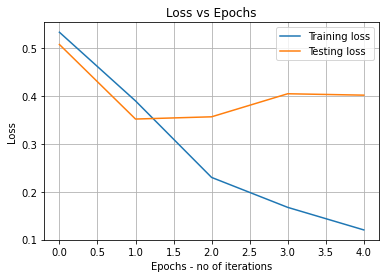

In [94]:
plt.plot(r1['Epochs'],r1['loss'],label='Training loss')
plt.plot(r1['Epochs'],r1['val_loss'],label='Testing loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs - no of iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

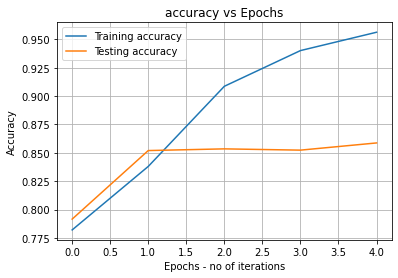

In [95]:
plt.plot(r1['Epochs'],r1['accuracy'],label='Training accuracy')
plt.plot(r1['Epochs'],r1['val_accuracy'],label='Testing accuracy')
plt.title('accuracy vs Epochs')
plt.xlabel('Epochs - no of iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [138]:
ypred = m1.predict(x_test_pad)
print(ypred)


84/84 [==============================] - 1s 9ms/step
[[0.9898869 ]
 [0.99383926]
 [0.9935915 ]
 ...
 [0.79335004]
 [0.99373996]
 [0.6185268 ]]


In [97]:
print(ypred.shape)

(2683, 1)


In [98]:
ypred_m1 = [1 if i>0.5 else 0 for i in ypred]
print(ypred_m1)

[1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

In [99]:
from sklearn.metrics import confusion_matrix,classification_report

In [100]:
cm = confusion_matrix(y_test,ypred_m1)
print(cm)
print(classification_report(y_test,ypred_m1,zero_division=0))

[[ 326  233]
 [ 146 1978]]
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       559
           1       0.89      0.93      0.91      2124

    accuracy                           0.86      2683
   macro avg       0.79      0.76      0.77      2683
weighted avg       0.85      0.86      0.85      2683



In [126]:
def predict_Positive_Negative(text):
    seq = tk.texts_to_sequences(text)
    pad = pad_sequences(seq, maxlen=30, padding='post')
    print(pad.shape)
    pred = m1.predict(pad)
    labels = {'Positive':0, 'Negative':1}
    pred_res = [1 if i>0.5 else 0 for i in pred]
    print('pred',pred)
    print('pred_res',pred_res)
    print(labels)
    

In [127]:
msg1 = ['He is a great leader.']
msg2 = ['He is a terrible leader.']
msg3 = ['He is a best leader.']

predict_Positive_Negative(msg1)
print('*'*20)
predict_Positive_Negative(msg2)
print('*'*20)
predict_Positive_Negative(msg3)

(1, 30)
1/1 [==============================] - 0s 22ms/step
pred [[0.359187]]
pred_res [0]
{'Positive': 0, 'Negative': 1}
********************
(1, 30)
1/1 [==============================] - 0s 20ms/step
pred [[0.97896224]]
pred_res [1]
{'Positive': 0, 'Negative': 1}
********************
(1, 30)
1/1 [==============================] - 0s 23ms/step
pred [[0.37346014]]
pred_res [0]
{'Positive': 0, 'Negative': 1}


#### inference: we are getting correct prediction